In [ ]:
# default_exp train

# train.py

> training model

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
from baseline_3d_pose.utils import *
from baseline_3d_pose.model import *
from baseline_3d_pose.dataset import *
from baseline_3d_pose.viz import *
from fastai.vision import *
from fastprogress.fastprogress import master_bar, progress_bar
import json
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.gridspec import GridSpec

In [ ]:
class AverageMeter():
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def lr_decay(optimizer, step, lr, decay_step, gamma):
    lr = lr * gamma ** (step/decay_step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [ ]:
class Options():
    def __init__(self):
        # paths
        self.data_path = Path('data')
        self.model_path = Path('model')
        
        # train options
        self.actions = 'All'
        self.attempt_id = '01'
        self.attempt_path = Path('model')/self.attempt_id
        
        self.load_ckpt = False
        
        # train hyper-params
        self.bs = 64*2
        self.epochs = 10
        self.lr = 1e-3
        self.lr_decay = 100000
        self.lr_gamma = 0.96
        
        self.start_epoch = 0
        self.err_best = 1000
        self.glob_step = 0 
        self.lr_now = self.lr
        
        # model hyper-params
        self.size = 1024
        self.stages = 2
        self.dropout = 0.5
        
        # metrics
        self.lr_list = []
        self.loss_list = []

In [ ]:
def save_options(options):
    options.attempt_path.mkdir(exist_ok=True)
    torch.save(options, options.attempt_path/'options.pt')

In [ ]:
def save_ckpt(model_state, optimizer_state, options, is_best=False):
    options.attempt_path.mkdir(exist_ok=True)
    model_name = 'best_model.pt' if is_best else 'last_model.pt'
    optimizer_name = 'best_optimizer.pt' if is_best else 'last_optimizer.pt'
    torch.save(model_state, options.attempt_path/model_name)
    torch.save(optimizer_state, options.attempt_path/optimizer_name)

In [ ]:
options = Options()

In [ ]:
stat_3d = torch.load(data_path/'stat_3d.pt')
stat_2d = torch.load(data_path/'stat_2d.pt')
train_set_3d = torch.load(data_path/'train_3d.pt')
test_set_3d = torch.load(data_path/'test_3d.pt')
train_set_2d = torch.load(data_path/'train_2d.pt')
test_set_2d = torch.load(data_path/'test_2d.pt')
rcams = torch.load(data_path/'rcams.pt')

mean_2d = stat_2d['mean']
std_2d = stat_2d['std']
dim_use_2d = stat_2d['dim_use']
dim_ignore_2d = stat_2d['dim_ignore']

mean_3d = stat_3d['mean']
std_3d = stat_3d['std']
dim_use_3d = stat_3d['dim_use']
dim_ignore_3d = stat_3d['dim_ignore']

In [ ]:
device = torch.device('cuda')

In [ ]:
def train(train_dl, model, criterion, optimizer, options, mb):
    losses = AverageMeter()
    model.train()
    for b, (xb, yb) in enumerate(progress_bar(train_dl, parent=mb)):
        options.glob_step += 1
        if options.glob_step % options.lr_decay == 0 or options.glob_step == 1:
            options.lr_now = lr_decay(optimizer, options.glob_step, options.lr, options.lr_decay, options.lr_gamma)
            
        xb, yb = xb.cuda(), yb.cuda()
        yhat = model(xb)
        optimizer.zero_grad()
        loss = criterion(yhat, yb)
        losses.update(loss.item(), xb.size(0))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        mb.child.comment = f'loss: {loss.item()}'
        options.loss_list.append(loss.item())
    return losses.avg

In [ ]:
avg_loss = []

model = Model()
model = model.cuda()
model.apply(init_kaiming)
print(f'total params: {sum(p.numel() for p in model.parameters())}')

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=options.lr)

if options.load_ckpt:
    options = torch.load('model/01/options.pt')
    model_state = torch.load(options.attempt_path/'last_model.pt')
    optimizer_state = torch.load(options.attempt_path/'last_optimizer.pt')
    model.load_state_dict(model_state)
    optimizer.load_state_dict(optimizer_state)

train_ds = Human36Dataset(get_actions(options.actions), options.data_path, is_train=True)

train_dl = DataLoader(train_ds, batch_size=options.bs, shuffle=True)

mb = master_bar(range(options.start_epoch, 1))
for epoch in mb:
    loss_avg = train(train_dl, model, criterion, optimizer, options, mb)
    mb.main_bar.comment = f'loss_avg: {loss_avg}'
    avg_loss.append(loss_avg)

total params: 4291632


In [ ]:
save_ckpt(model.state_dict(), optimizer.state_dict(), options)

In [ ]:
save_options(options)

In [ ]:
model = Model()
model = model.cuda()

In [ ]:
model_state = torch.load(options.attempt_path/'last_model.pt')
model.load_state_dict(model_state)

<All keys matched successfully>

In [ ]:
model.eval()

Model(
  (relu): ReLU(inplace=True)
  (drop): Dropout(p=0.5, inplace=False)
  (ln_in): Linear(in_features=32, out_features=1024, bias=True)
  (bn_in): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lins): ModuleList(
    (0): ResLinear(
      (relu): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (ln1): Linear(in_features=1024, out_features=1024, bias=True)
      (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ln3): Linear(in_features=1024, out_features=1024, bias=True)
      (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResLinear(
      (relu): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (ln1): Linear(in_features=1024, out_features=1024, bias=True)
      (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ln3): Linear(in_features=1024, out_features=1024,

In [ ]:
test_ds = Human36Dataset(get_actions(options.actions), options.data_path, is_train=False)
test_dl = DataLoader(test_ds, batch_size=options.bs, shuffle=False)

In [ ]:
xb, yb = next(iter(test_dl))

In [ ]:
idx = 40
xt = xb[idx].unsqueeze(0).cuda()
yt = yb[idx].unsqueeze(0)
yh = model(xt)

In [ ]:
y1 = yh.detach().cpu().numpy()

In [ ]:
y2 = yt.numpy()

In [ ]:
y1, y2

(array([[ 1.014459, -0.819197,  1.141519,  0.54453 ,  0.544552,  0.240389,  0.73348 ,  0.76719 , -0.176274, -1.014463,
          0.819009, -1.141369, -1.15151 ,  0.609021, -0.243955, -0.983194,  0.789744, -0.533866,  0.234221, -0.649417,
         -0.329033,  0.080633, -0.603357,  0.117524, -0.351832, -0.717593,  0.542456, -0.206063, -0.750812,  0.416999,
         -0.726214, -0.515889, -0.667661, -1.049081, -0.237211, -1.244255, -1.886471,  0.11505 , -0.748346,  1.013946,
         -0.600586,  0.549128,  1.445736, -0.289393,  0.600995,  1.745043,  0.228051,  1.111089]], dtype=float32),
 array([[ 0.864646, -0.799932,  1.051004,  0.679665,  0.654851,  0.290095,  0.808638,  0.901064, -0.086821, -0.864653,
          0.799941, -1.051013, -1.026088,  0.764314, -0.199174, -0.992735,  0.955896, -0.563551,  0.269595, -0.811189,
          0.214479,  0.094018, -0.67636 ,  0.400698, -0.409346, -0.881282,  0.617105, -0.293451, -0.999364,  0.588144,
         -0.695997, -0.497907, -0.620328, -1.061561,

In [ ]:
y1 = unnormalize_data(y1, mean_3d, std_3d, dim_ignore_3d)
y2 = unnormalize_data(y2, mean_3d, std_3d, dim_ignore_3d)

ValueError: shape mismatch: value array of shape (1,96) could not be broadcast to indexing result of shape (48,1)

In [ ]:
key = train_ds.get_key(3)

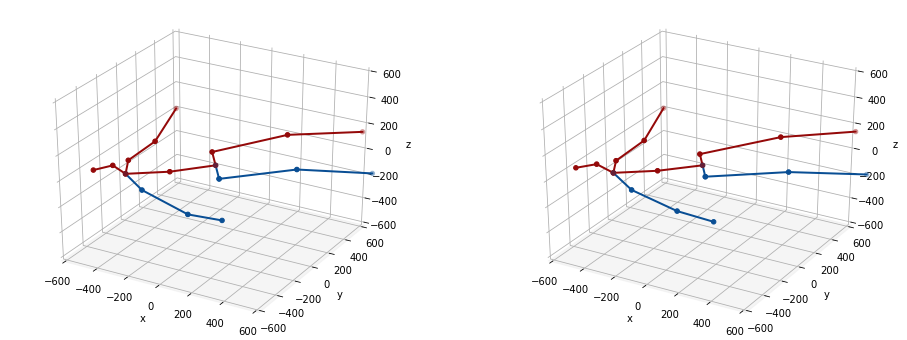

In [ ]:
plt.figure(figsize=(16,6))
gs2 = GridSpec(1,2)
ax1 = plt.subplot(gs2[0], projection='3d')
ax2 = plt.subplot(gs2[1], projection='3d')

y1 = cam_to_world_centered(y1 , key, rcams)
y2 = cam_to_world_centered(y2 , key, rcams)

show_3d_pose(y1, ax1)
show_3d_pose(y2, ax2)

plt.show()